In [24]:
from sklearn import decomposition
import math
from math import sqrt
import pandas as pd
from sklearn.cluster import KMeans
# own modules
from text_embeddings.preprocessing.read_pdf import *
from user_interface.cli import *
from doc_images.pdf_matrix import *
from elasticSearch.queries.query_documents_tfidf import *
from text_embeddings.universal_sent_encoder_tensorFlow import *
from text_embeddings.hugging_face_sentence_transformer import *

image_src_path = '/Users/klara/Documents/Uni/bachelorarbeit/images/*.png'
IMG_SIZE = 600

In [25]:
image_paths = glob.glob(image_src_path)
preprocessed_images = np.array([np.reshape(a=
                                    cv2.normalize(
    cv2.resize(
        cv2.imread(img, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)), 
        None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        , newshape=IMG_SIZE**2) 
        for img in image_paths])

In [26]:

# center the images, cf. https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py
# Global centering (focus on one feature, centering all samples)
preprocessed_images_centered = preprocessed_images - np.mean(preprocessed_images, axis=0)
# Local centering (focus on one sample, centering all features)
preprocessed_images_centered -= preprocessed_images_centered.mean(axis=1).reshape(len(preprocessed_images_centered), -1)

shape of all data:  (194, 360000)


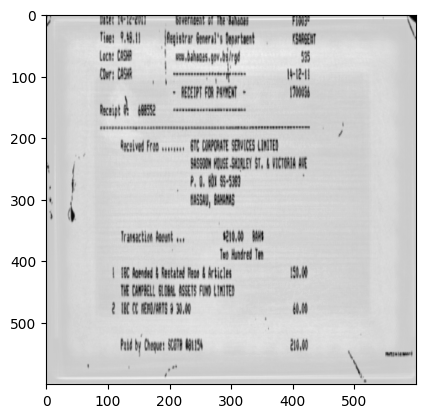

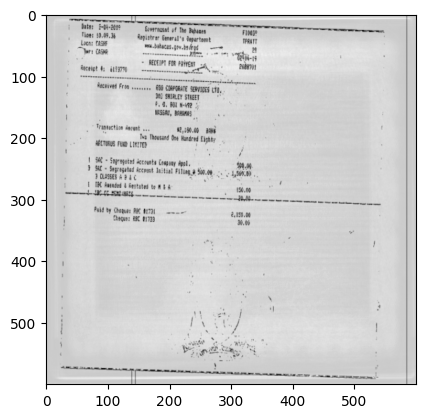

In [27]:

print('shape of all data: ', preprocessed_images_centered.shape)    # (n_samples, n_features)
for img in preprocessed_images_centered[:2]:
    plt.imshow(img.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.show()

In [28]:
# PCA needs more samples than features, cf. https://stackoverflow.com/questions/51040075/why-sklearn-pca-needs-more-samples-than-new-featuresn-components
# otherwise the number of new faetures will be way smaller than the original number of features
# number of components to keep: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
# SVD: https://en.wikipedia.org/wiki/Eigenface#Computing_the_eigenvectors
pca = decomposition.PCA(n_components=194, svd_solver="randomized", whiten=True)
#print(preprocessed_images[0].shape)
pca_img = pca.fit_transform(preprocessed_images_centered)
print('PCA components: ', pca.components_.shape)    # (n_new_features/ n_components, n_features)
print('PCA return shape: ', pca_img.shape)  # (n_samples, n_new_features/ n_components)
print('PCA image: ', pca_img)

PCA components:  (194, 360000)
PCA return shape:  (194, 194)
PCA image:  [[-0.34640476 -0.32709542  0.23501372 ... -0.19346008 -0.2662857
   0.99741983]
 [-0.3662525   0.29789373  0.5296094  ... -0.4689059  -0.06704082
   0.99741703]
 [ 0.5669695   0.20851833  9.160379   ... -0.31906706  0.1738109
   0.99741673]
 ...
 [-0.20440593 -0.4825759  -0.04618948 ...  0.2285902  -0.0187393
   0.99741745]
 [ 3.3647866   1.4134171  -0.38376185 ... -0.02488847  0.07399008
   0.99742126]
 [-0.38864124 -0.08948919 -0.43944597 ... -0.11502143  0.07869952
   0.9974172 ]]


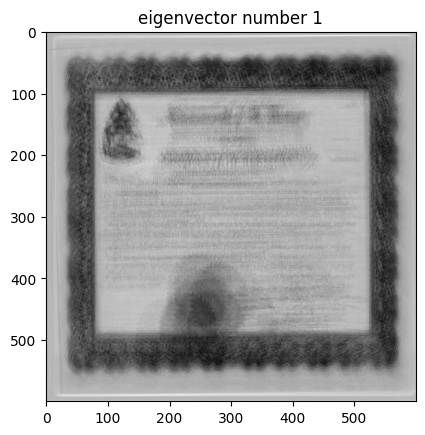

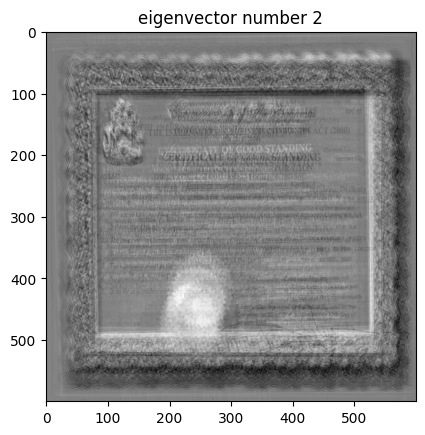

In [29]:
# plot eigenvectors as images
i = 1
for img in pca.components_[:2]: # component is (parallel to) eigenvector, cf. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform
    plt.imshow(img.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title('eigenvector number ' + str(i))
    i += 1
    plt.show()

    # compare eigenvectors to get 'what they show (eg. Belichtung, Kontrast, etc.)'
    # TODO: residuals/ rescosntruction error, to see how much information is lost, if representative

In [30]:
# save representation of images in lower dimension (linear combination of eigenvectors) in dataframe
pca_df = pd.DataFrame({'path': image_paths, 'pca_weights': 0})
pca_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    pca_df.loc[[image_paths[i]], 'pca_weights'] = pd.Series([pca_img[i]], index=pca_df.index[[i]])

pca_df

,pca_weights
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.34640476, -0.32709542, 0.23501372, 0.83860..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.3662525, 0.29789373, 0.5296094, -0.0256349..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.5669695, 0.20851833, 9.160379, 1.9109466, 5..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.28844553, 0.30944964, 0.7689679, 0.3911343..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365496, -0.42438853, -0.54458016, -0.178..."
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549206, -0.070531584, -0.67868227, -0.00..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.3004062, 0.053426757, 0.16827245, 0.259833..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440593, -0.4825759, -0.046189476, 0.0868..."


In [31]:
# identify clusters by similar weights (linear combination) of eigenvectors
NUM_CLASSES = 4
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(pca_df['pca_weights'].to_list())
pca_df['cluster'] = kmeans.labels_
display(pca_df)

,pca_weights,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.34640476, -0.32709542, 0.23501372, 0.83860...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.3662525, 0.29789373, 0.5296094, -0.0256349...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.5669695, 0.20851833, 9.160379, 1.9109466, 5...",1
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.28844553, 0.30944964, 0.7689679, 0.3911343...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365496, -0.42438853, -0.54458016, -0.178...",1
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549206, -0.070531584, -0.67868227, -0.00...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.3004062, 0.053426757, 0.16827245, 0.259833...",1
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440593, -0.4825759, -0.046189476, 0.0868...",3


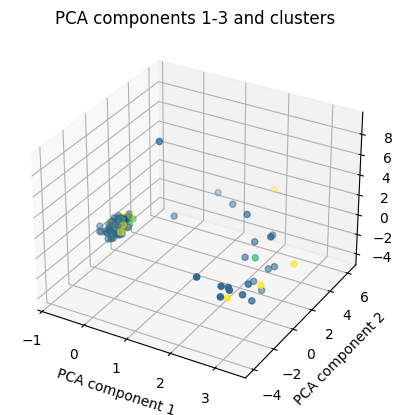

In [47]:
# plot first 3 principal components & clusters
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca_x1 = pca_df['pca_weights'].apply(lambda x: x[0])
pca_x2 = pca_df['pca_weights'].apply(lambda x: x[1])
pca_x3 = pca_df['pca_weights'].apply(lambda x: x[2])

ax.scatter(pca_x1, pca_x2, pca_x3, marker='o', c=pca_df['cluster'])
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
ax.set_zlabel('PCA component 3')
plt.title('PCA components 1-3 and clusters')

plt.show()

In [ ]:
# plot first 4 principal components
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca_x1 = pca_df['pca_weights'].apply(lambda x: x[0])
pca_x2 = pca_df['pca_weights'].apply(lambda x: x[1])
pca_x3 = pca_df['pca_weights'].apply(lambda x: x[2])
pca_x4 = pca_df['pca_weights'].apply(lambda x: x[3])

ax.scatter(pca_x1, pca_x2, pca_x3, marker='o', c=pca_x4)
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
ax.set_zlabel('PCA component 3')
plt.title('PCA components 1-4 and NO clusters')

plt.show()

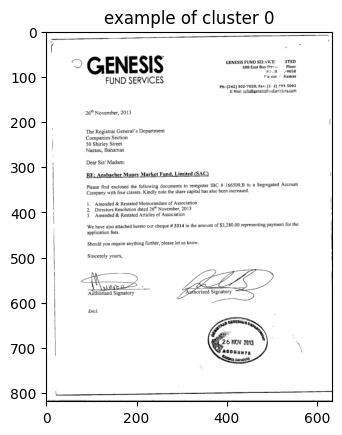

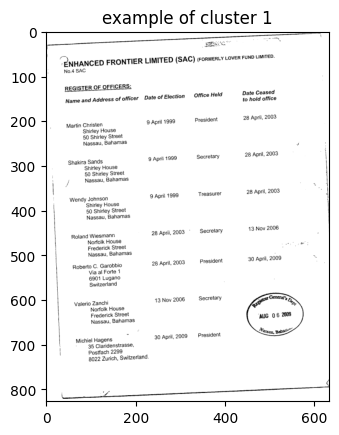

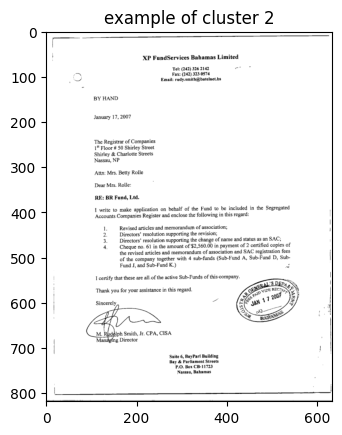

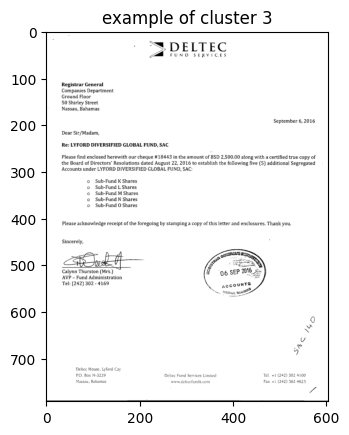

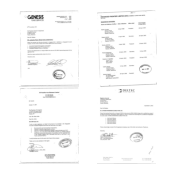

In [32]:
# display sample document per class
example_images = []
for i in range(NUM_CLASSES):
    example_img = pca_df[pca_df['cluster'] == i].sample(1).index.values[0]
    example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of cluster ' + str(i))
    plt.show()

create_image_matrix(example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

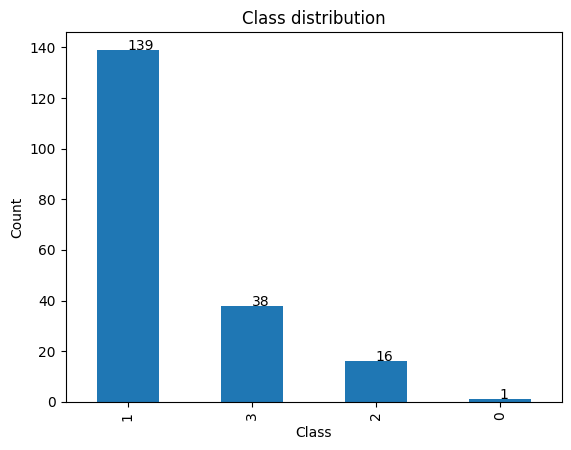

In [33]:
# class/ cluster distribution
pca_df['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
cluster_counts = pca_df['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(pca_df['cluster'].value_counts())):
        plt.text(i, cluster_counts[i], cluster_counts[i])

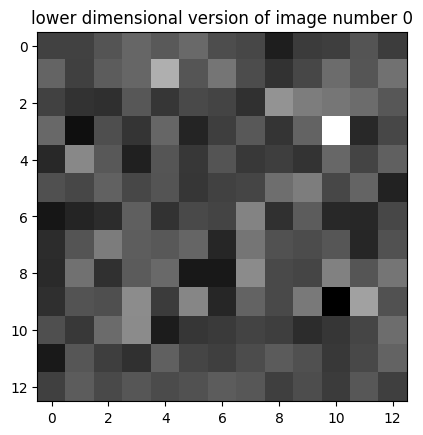

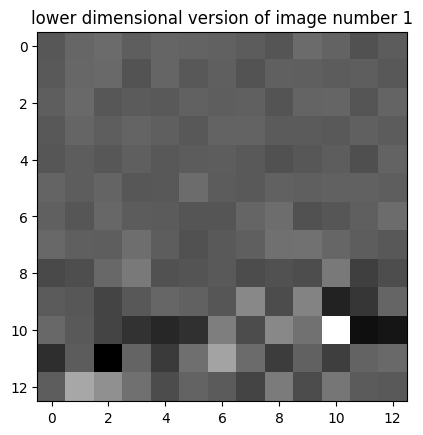

In [34]:
# visualize the compressed data, i.e. the weights/ factors of PCA components, as an image
# transformed pictures in lower dimensional subspace (weights of PCA components)
for i in range(len(pca_img[:2])):
    img = pca_img[i]
    dim = int(sqrt(len(img)))
    # automatically transform image using -1, cf. https://www.datacamp.com/tutorial/principal-component-analysis-in-python
    quadratic_img = img[:dim**2].reshape(-1, dim)
    plt.imshow(quadratic_img, cmap='gray')
    plt.title('lower dimensional version of image number ' + str(i))
    plt.show()

##### 2 dimensional PCA

In [35]:
# use PCA to reduce dimensionality (image -> point in 2 dimensional space)
# cf. https://www.datacamp.com/tutorial/principal-component-analysis-in-python
# SVD: https://en.wikipedia.org/wiki/Eigenface#Computing_the_eigenvectors
d2_pca = decomposition.PCA(n_components=2, svd_solver="randomized", whiten=True)
#print(preprocessed_images[0].shape)
pca_2d_img = d2_pca.fit_transform(preprocessed_images_centered)
print('PCA components: ', d2_pca.components_.shape, 'Principal axes in feature space = directions of maximum variance')    # (n_new_features/ n_components, n_features)
print('PCA return/ image shape: ', pca_2d_img.shape)  # (n_samples, n_new_features/ n_components)
print('PCA image: ', pca_2d_img)

PCA components:  (2, 360000) Principal axes in feature space = directions of maximum variance
PCA return/ image shape:  (194, 2)
PCA image:  [[-3.46403211e-01 -3.28056365e-01]
 [-3.66249889e-01  2.98106521e-01]
 [ 5.66969633e-01  2.04832509e-01]
 [-2.88445592e-01  3.09541702e-01]
 [-4.33654755e-01 -4.23954785e-01]
 [-3.60889018e-01  3.50359827e-01]
 [-4.89749789e-01 -3.34507436e-01]
 [-4.69095320e-01 -2.16948196e-01]
 [-2.59473652e-01 -1.34109065e-01]
 [ 2.68319130e+00  1.91927803e+00]
 [-4.73633528e-01 -4.85064864e-01]
 [-5.46603680e-01  1.05462953e-01]
 [ 3.07976770e+00  2.38186270e-01]
 [-4.15832937e-01 -8.61040354e-02]
 [-1.90707341e-01  2.15785891e-01]
 [-4.07719433e-01  1.73336431e-01]
 [-2.66363293e-01  5.75207233e-01]
 [-3.82630855e-01  4.01703380e-02]
 [-1.74659759e-01  2.53404021e-01]
 [-3.16851318e-01  2.35438824e-01]
 [-2.79990494e-01 -2.79373020e-01]
 [-2.27828339e-01 -1.69501245e-01]
 [-3.84884447e-01 -5.10760427e-01]
 [-5.38831830e-01 -6.42995238e-01]
 [-5.22882342e-01 -

In [36]:
# save representation of images by linear combination of eigenvectors in dataframe
pca_2d_df = pd.DataFrame({'path': image_paths, 'pca_weights': 0})
pca_2d_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    pca_2d_df.loc[[image_paths[i]], 'pca_weights'] = pd.Series([pca_2d_img[i]], index=pca_2d_df.index[[i]])

pca_2d_df.to_json('pca_2d_df.json', index=True)
pca_2d_df

,pca_weights
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.3464032, -0.32805637]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.3662499, 0.29810652]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.56696963, 0.20483251]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.2884456, 0.3095417]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365476, -0.42395478]"
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549254, -0.070479825]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30040613, 0.053801075]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440577, -0.482652]"


In [37]:
# identify clusters by similar weights (linear combination) of eigenvectors
d2_kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['cluster'] = d2_kmeans.labels_
display(pca_2d_df)

,pca_weights,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.3464032, -0.32805637]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.3662499, 0.29810652]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.56696963, 0.20483251]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.2884456, 0.3095417]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43365476, -0.42395478]",0
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549254, -0.070479825]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30040613, 0.053801075]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440577, -0.482652]",0


Text(0.5, 1.0, '2D representation of images clustered by KMeans')

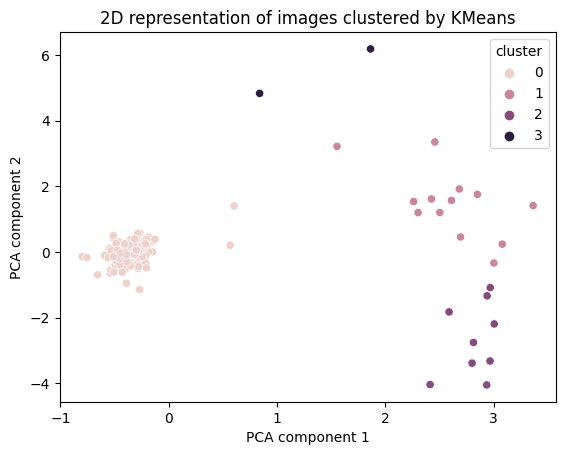

In [38]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by KMeans')

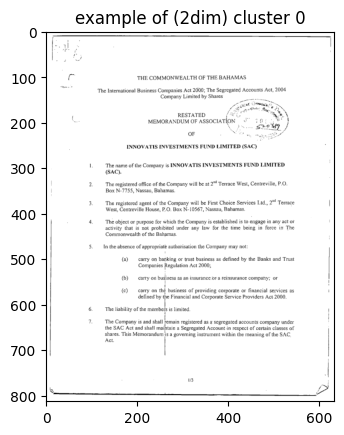

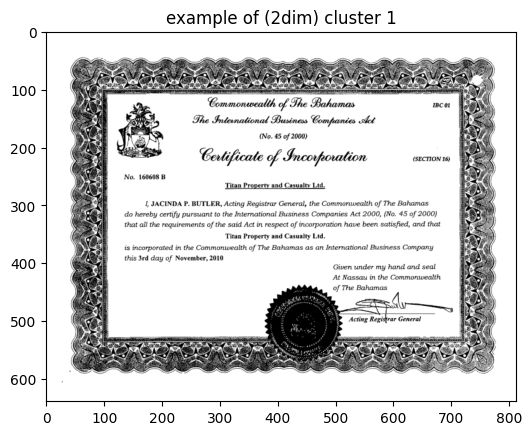

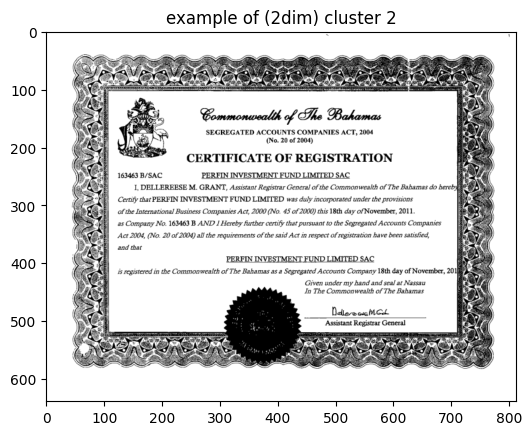

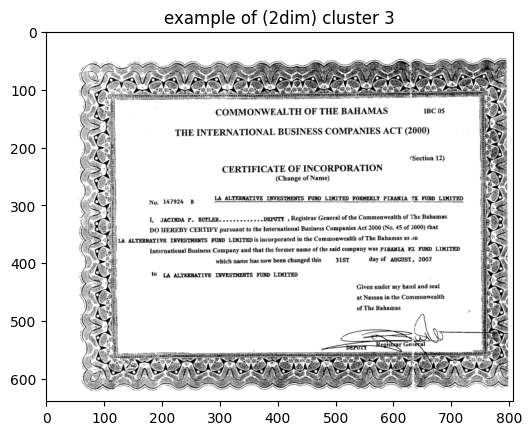

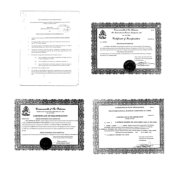

In [39]:
# display sample document per class
d2_example_images = []
for i in range(NUM_CLASSES):
    example_img = pca_2d_df[pca_2d_df['cluster'] == i].sample(1).index.values[0]
    d2_example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of (2dim) cluster ' + str(i))
    plt.show()

create_image_matrix(d2_example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

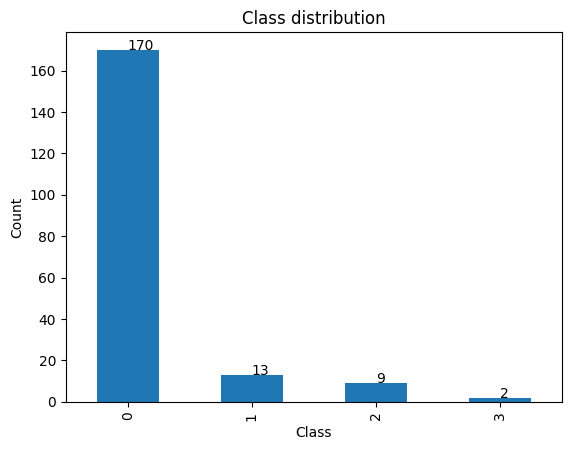

In [40]:
# class/ cluster distribution
pca_2d_df['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
d2_cluster_counts = pca_2d_df['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(pca_2d_df['cluster'].value_counts())):
        plt.text(i, d2_cluster_counts[i], d2_cluster_counts[i])

# PCA

### PCA components: 
- Principal axes in feature space = directions of maximum variance
- Parallel to eigenvectors

### PCA explained variance:
- Amount of variance explained by each of the selected components
- Ratio: same, but percentage

### PCA n_components:
- Number of components to keep

### PCA return values:
- samples in new (lower dimensional) feature space
